In [1]:
import pycolmap
from pathlib import Path
import os
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

### 1. Reconstruction

In [2]:
scene_folder = Path('../data/south-building')
images_folder = scene_folder / 'images'
database_path = scene_folder / 'database.db'
output_path = scene_folder / 'undistorted_images'
os.makedirs(output_path, exist_ok=True)

#### 2.1 Sparse Reconstruction

In [3]:
if not os.path.exists(scene_folder / '0'):
    pycolmap.extract_features(database_path, images_folder, camera_model='SIMPLE_PINHOLE')
    pycolmap.match_exhaustive(database_path)
    maps = pycolmap.incremental_mapping(database_path, images_folder, scene_folder)
    maps[0].write(scene_folder)
    pycolmap.undistort_images(output_path=str(output_path), image_path=str(images_folder), input_path=scene_folder / '0')

#### 2.2 Examining Reconstruction

Reconstruction consists of three elements: images, points and cameras

In [4]:
reconstruction = pycolmap.Reconstruction(output_path / 'sparse')
print(reconstruction.summary())

Reconstruction:
	num_reg_images = 128
	num_cameras = 1
	num_points3D = 57713
	num_observations = 324248
	mean_track_length = 5.61828
	mean_observations_per_image = 2533.19
	mean_reprojection_error = 0.758


In [5]:
help(reconstruction)

Help on Reconstruction in module pycolmap object:

class Reconstruction(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      Reconstruction
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __copy__(...)
 |      __copy__(self: pycolmap.Reconstruction) -> pycolmap.Reconstruction
 |  
 |  __deepcopy__(...)
 |      __deepcopy__(self: pycolmap.Reconstruction, arg0: dict) -> pycolmap.Reconstruction
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: pycolmap.Reconstruction) -> None
 |      
 |      2. __init__(self: pycolmap.Reconstruction, sfm_dir: str) -> None
 |  
 |  __repr__(...)
 |      __repr__(self: pycolmap.Reconstruction) -> str
 |  
 |  add_camera(...)
 |      add_camera(self: pycolmap.Reconstruction, arg0: pycolmap.Camera) -> None
 |      
 |      Add new camera. There is only one camera per image, while multiple images
 |      might be 

In [53]:
images_subset = list(reconstruction.images.items())[:10]
for image_id, image in images_subset:
    print(image_id, image)

1 Image(image_id=1, camera_id=1, name="P1180141.JPG", triangulated=1829/11186)
2 Image(image_id=2, camera_id=1, name="P1180142.JPG", triangulated=1880/8620)
3 Image(image_id=3, camera_id=1, name="P1180143.JPG", triangulated=1365/5717)
4 Image(image_id=4, camera_id=1, name="P1180144.JPG", triangulated=1099/9548)
5 Image(image_id=5, camera_id=1, name="P1180145.JPG", triangulated=373/5889)
6 Image(image_id=6, camera_id=1, name="P1180146.JPG", triangulated=641/9453)
7 Image(image_id=7, camera_id=1, name="P1180147.JPG", triangulated=1013/11138)
8 Image(image_id=8, camera_id=1, name="P1180148.JPG", triangulated=1194/11172)
9 Image(image_id=9, camera_id=1, name="P1180149.JPG", triangulated=1191/10432)
10 Image(image_id=10, camera_id=1, name="P1180150.JPG", triangulated=808/6822)


In [52]:
points_3d_subset = list(reconstruction.points3D.items())[:10]
for point3D_id, point3D in points_3d_subset:
    print(point3D)

Point3D(xyz=[-0.291721, -0.58457, -0.378086], color=[188, 162, 149], error=0.831657, track=Track(length=25))
Point3D(xyz=[0.569459, -1.40484, -0.0677889], color=[187, 189, 186], error=0.411399, track=Track(length=7))
Point3D(xyz=[1.36895, -0.165136, 1.43573], color=[58, 54, 44], error=0.609997, track=Track(length=5))
Point3D(xyz=[-2.13608, -0.585409, 1.61888], color=[186, 167, 151], error=0.678389, track=Track(length=3))
Point3D(xyz=[-0.834074, -1.10561, -0.197707], color=[195, 197, 194], error=1.16137, track=Track(length=17))
Point3D(xyz=[0.997199, -0.490985, -0.247889], color=[175, 152, 138], error=0.500987, track=Track(length=11))
Point3D(xyz=[-2.34877, -0.452898, 1.59921], color=[194, 165, 146], error=0.393348, track=Track(length=4))
Point3D(xyz=[1.05781, -1.2999, -0.0134596], color=[127, 124, 119], error=0.757218, track=Track(length=5))
Point3D(xyz=[0.961135, -0.918643, -0.125296], color=[105, 79, 90], error=0.28088, track=Track(length=5))
Point3D(xyz=[1.02439, -1.29927, -0.014692

In [8]:
for camera_id, camera in reconstruction.cameras.items():
    print(camera_id, camera)

1 Camera(camera_id=1, model=SIMPLE_PINHOLE, width=3072, height=2304, params=[2595.776084, 1536.000000, 1152.000000] (f, cx, cy))


In [9]:
width = reconstruction.cameras[1].width
height = reconstruction.cameras[1].height

### 2. Extrinsic & Intrinsic Matrix

#### 2.1 Camera

3D points are in the world coordinates and one of the steps is transforming them to the camera coordinate system.

In [10]:
img = reconstruction.images[50]
img_name = img.name
help(img.cam_from_world)

Help on Rigid3d in module pycolmap object:

class Rigid3d(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      Rigid3d
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __copy__(...)
 |      __copy__(self: pycolmap.Rigid3d) -> pycolmap.Rigid3d
 |  
 |  __deepcopy__(...)
 |      __deepcopy__(self: pycolmap.Rigid3d, arg0: dict) -> pycolmap.Rigid3d
 |  
 |  __getstate__(...)
 |      __getstate__(self: pycolmap.Rigid3d) -> dict
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: pycolmap.Rigid3d) -> None
 |      
 |      2. __init__(self: pycolmap.Rigid3d, arg0: pycolmap.Rotation3d, arg1: numpy.ndarray[numpy.float64[3, 1]]) -> None
 |      
 |      3. __init__(self: pycolmap.Rigid3d, arg0: numpy.ndarray[numpy.float64[3, 4]]) -> None
 |      
 |      4. __init__(self: pycolmap.Rigid3d, arg0: dict) -> None
 |      
 |      5. __init__(self: pycolmap.

#### 2.2 Homogeneous coordinates
These are coordinates with added extra dimension. For a point in 3D coordinates, $v = (x, y, z)$, it transforms to 4D $v_h = (x, y, z, 1)$.

In [11]:
points = np.array([point.xyz for point in reconstruction.points3D.values()])
print(points[:2])
homogeneous_points = np.concatenate((points, np.ones((len(points), 1), np.float32)), axis=1)
print(homogeneous_points[:2])

[[-0.29172067 -0.58457    -0.37808574]
 [ 0.56945923 -1.40483576 -0.06778892]]
[[-0.29172067 -0.58457    -0.37808574  1.        ]
 [ 0.56945923 -1.40483576 -0.06778892  1.        ]]


#### 2.3 Extrinsic Matrix
These parameters are **rotation** and **translation** of the camera in the world coordinate system. The rotation can be expressed by quarternion (that uses only 4x1 matrix instead of 3x3 matrix). The translation vector tells the camera's position relative to the origin.

\begin{pmatrix}
r_{11} & r_{12} & r_{13} & t_{x} \\
r_{21} & r_{22} & r_{23} & t_{y} \\
r_{31} & r_{32} & r_{33} & t_{z} \\
0 & 0 & 0 & 1
\end{pmatrix}

It is used to translate world coordinate system to camera coordinate system.

In [12]:
print(img.cam_from_world)

Rigid3d(quat_xyzw=[0.00830674, -0.754076, 0.228768, 0.615601], t=[-0.220959, 1.41791, 4.9713])


In [13]:
print(img.cam_from_world.matrix()) # [R | t] matrix

[[-0.24193216 -0.29418794 -0.92462008 -0.22095875]
 [ 0.26913228  0.89519213 -0.35524481  1.41790854]
 [ 0.93222135 -0.33479025 -0.13740029  4.97129977]]


In [14]:
extrinsic_matrix = np.concatenate((img.cam_from_world.matrix(), np.array([[0, 0, 0, 1]])))
extrinsic_matrix

array([[-0.24193216, -0.29418794, -0.92462008, -0.22095875],
       [ 0.26913228,  0.89519213, -0.35524481,  1.41790854],
       [ 0.93222135, -0.33479025, -0.13740029,  4.97129977],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [15]:
projected_to_camera_viewpoint = (extrinsic_matrix @ homogeneous_points.T)
projected_to_camera_viewpoint.shape

(4, 57713)

#### 2.4 Intrinsic Matrix
This is needed to perform transformation between a point P in the 3D camera reference system to a point P' in the 2D image plane.

 \begin{pmatrix}
 f_x & 0 & c_x & 0 \\
 0 & f_y & c_y & 0 \\
 0 & 0 & 1 & 0
 \end{pmatrix}

- $f_x$, $f_y$ : focal length
- $c_x$, $c_y$ : translation vector that describes offset between digital and camera coordinates

(this form of matrix is needed to make translations on 3D points)

In [16]:
f, cx, cy = reconstruction.cameras[1].params
intrinsic_matrix = np.array([[f, 0, cx, 0], [0, f, cy, 0], [0, 0, 1, 0]])

In [17]:
projected_to_image_viewpoint = (intrinsic_matrix @ projected_to_camera_viewpoint).T

In [18]:
projected_to_image_viewpoint.shape

(57713, 3)

Next, points need to be normalized to go back from homogenous coordinates (3D) to 2D points.

In [19]:
projected_points = np.array(projected_to_image_viewpoint[:, :2])
projected_points[:, 0] /= projected_to_image_viewpoint[:, 2]
projected_points[:, 1] /= projected_to_image_viewpoint[:, 2]

### 3. Projection 1

First way of projecting 3D point cloud to 2D using extrinsic and intrinsic matrices derived above.



In [20]:
colors = np.array([p.color for p in reconstruction.points3D.values()]) / 255.0

In [21]:
points_ids = np.where((projected_points[:, 0] > 0) & (projected_points[:, 0] < width) & (projected_points[:, 1] > 0) & (projected_points[:, 1] < height))[0]
selected_points = projected_points[points_ids]
selected_colors = colors[points_ids]

It is not really upside down, it's that the point (0, 0) is in the wrong place - it should be in the upper left corner, not in the lower left.

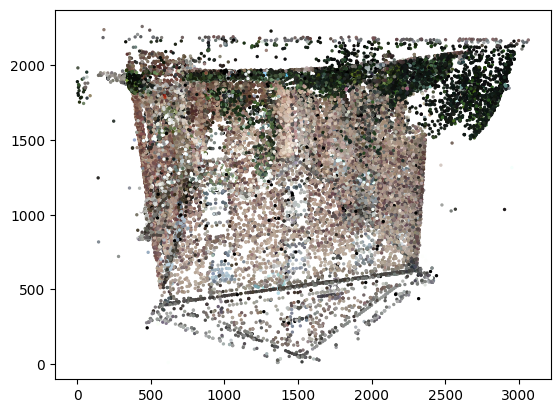

In [22]:
plt.scatter(selected_points[:, 0], selected_points[:, 1], s=2, c=selected_colors)

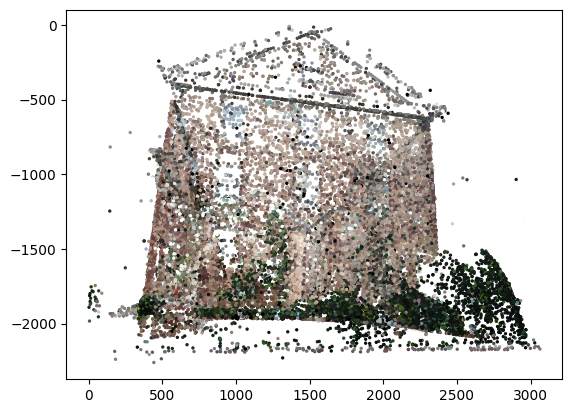

In [23]:
plt.scatter(selected_points[:, 0], -selected_points[:, 1], s=2, c=selected_colors)

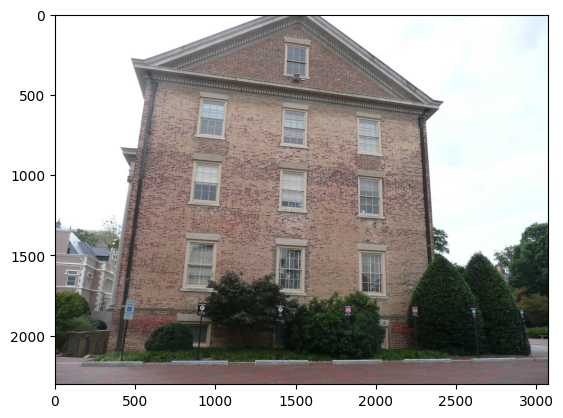

In [24]:
image = mpimg.imread(output_path / f'images/{img_name}')
plt.imshow(image)

### 4. Perspective projection (OPENGL)

Another, probably more correct way is to perform projection using opengl perspective matrix.

$$\begin{pmatrix}
\frac{2n}{r - l} & 0 & \frac{r + l}{r - l} & 0 \\
0 & \frac{2n}{t - b} & \frac{t + b}{t - b} & 0 \\
0 & 0 & - \frac{f + n}{f - n} & \frac{-2fn}{f - n} \\
0 & 0 & -1 & 0
\end{pmatrix}$$

where
- $n, f$ - near, far are distances of near and far clipping planes
- $l, t, r, b$ - left, top, right, bottom are coordinates boundaries

It actually encloses points into the viewing volume of camera - called clip space

<div>
<img src="images/projectionOpenGL2.png" width="400">
</div>

In [25]:
focal_x, focal_y = f, f
znear = 1
zfar = 5

# https://stackoverflow.com/questions/39992968/how-to-calculate-field-of-view-of-the-camera-from-camera-intrinsic-matrix
fov_x = np.array([2 * math.atan(width / (2 * focal_x))])
fov_y = np.array([2 * math.atan(height / (2 * focal_y))])

tan_half_foc_x = math.tan((fov_x / 2))
tan_half_foc_y = math.tan((fov_y / 2))

top = tan_half_foc_y * znear
bottom = -top
right = tan_half_foc_x * znear
left = -right

P = np.zeros((4, 4))

z_sign = 1.0

P[0, 0] = 2.0 * znear / (right - left)
P[1, 1] = 2.0 * znear / (top - bottom)
P[0, 2] = (right + left) / (right - left)
P[1, 2] = (top + bottom) / (top - bottom)
P[3, 2] = z_sign
P[2, 2] = z_sign * (zfar + znear) / (zfar - znear) # this is to make depth be in range [0, 1]
P[2, 3] = -(zfar * znear) / (zfar - znear) # this is to make depth be in range [0, 1]

C:\Users\julia\AppData\Local\Temp\ipykernel_26040\3951536483.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tan_half_foc_x = math.tan((fov_x / 2))
C:\Users\julia\AppData\Local\Temp\ipykernel_26040\3951536483.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tan_half_foc_y = math.tan((fov_y / 2))


In [26]:
P

array([[ 1.68995839,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  2.25327785,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.5       , -1.25      ],
       [ 0.        ,  0.        ,  1.        ,  0.        ]])

In [27]:
clip_coordinates = (homogeneous_points @ extrinsic_matrix.T @ P)

In [28]:
clip_coordinates

array([[ 0.62727363,  2.14153244,  8.42051344, -6.1837612 ],
       [ 0.19812309,  0.76082412,  9.97270204, -7.4772517 ],
       [-3.09443754,  2.54276786, 10.15822622, -7.63185518],
       ...,
       [-1.42232836,  0.56662579,  4.24513709, -2.70428091],
       [-2.52455347, -0.77387665,  6.46078322, -4.55065268],
       [-2.53152147,  3.04513098,  9.05853943, -6.71544952]])

Next, points in the clip space are converted to **NDC** coordinates. This technique is used in graphics where GPU would throw away points outside of the frustrum. But here I decided to throw away points after converting them to NDC and it probably works idk.

<div>
<img src="images/perspective_projection_stages.png" width="800">
</div>

In [29]:
ndc_coordinates = np.copy(clip_coordinates[:, :3])
ndc_coordinates[:, 0] = ndc_coordinates[:, 0] / clip_coordinates[:, 3]
ndc_coordinates[:, 1] = ndc_coordinates[:, 1] / clip_coordinates[:, 3]
ndc_coordinates[:, 2] = ndc_coordinates[:, 2] / clip_coordinates[:, 3]

In [30]:
selected_ids = (-1 < ndc_coordinates[:, 0]) & (ndc_coordinates[:, 0] < 1) & (-1 < ndc_coordinates[:, 1]) & (ndc_coordinates[:, 1] < 1)

In [31]:
np.sum(selected_ids)

np.int64(57092)

In [32]:
c = colors[selected_ids]
p = ndc_coordinates[selected_ids]

Looks like it works!

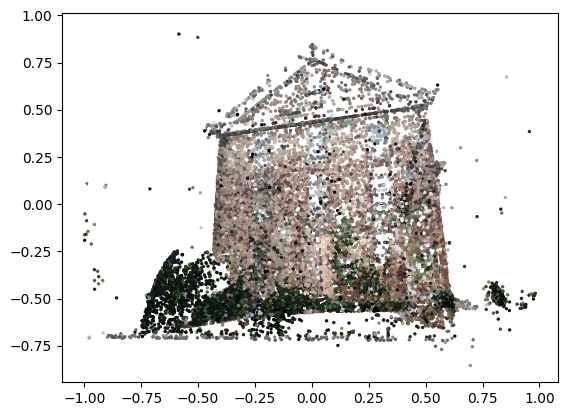

In [33]:
plt.scatter(p[:, 0], p[:, 1], s=2, c=c)

Next, we need to actually convert it to screen coordinates

In [34]:
x_off, y_off = 0, 0

screen_coordinates = np.zeros((len(p), 3))

screen_coordinates[:, 0] = x_off + 0.5 * (-p[:, 0] + 1) * width
screen_coordinates[:, 1] = y_off + 0.5 * (-p[:, 1] + 1) * height
screen_coordinates[:, 2] = 0.5 * (zfar - znear) * p[:, 2] + 0.5 * (zfar + znear)  # can be used to resolve depth

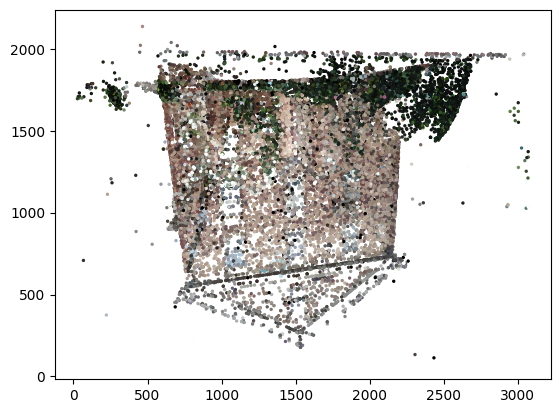

In [35]:
plt.scatter(screen_coordinates[:, 0], screen_coordinates[:, 1], s=2, c=c)

In [36]:
screen_coordinates.shape

(57092, 3)

In [37]:
corner = screen_coordinates[1000]

In [38]:
corner

array([1.52190466e+03, 1.43173697e+03, 3.38571566e-01])

In [39]:
subset = screen_coordinates[((screen_coordinates[:, 0] > corner[0]) & (screen_coordinates[:, 0] < (corner[0] + 16))) & ((screen_coordinates[:, 1] > corner[1]) & (screen_coordinates[:, 1] < (corner[1] + 16)))]

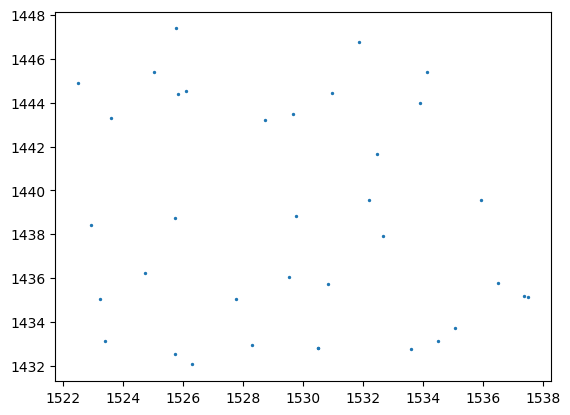

In [40]:
plt.scatter(subset[:, 0], subset[:, 1], s=2)

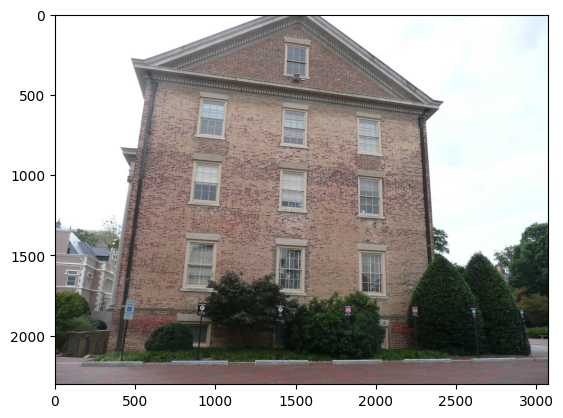

In [41]:
image = mpimg.imread(output_path / f'images/{img_name}')
plt.imshow(image)

In [42]:
image.shape

(2304, 3072, 3)

In [43]:
image.size

21233664

In [44]:
screen_coordinates.shape

(57092, 3)

#### Changing image size

In [45]:
from skimage.transform import downscale_local_mean, resize

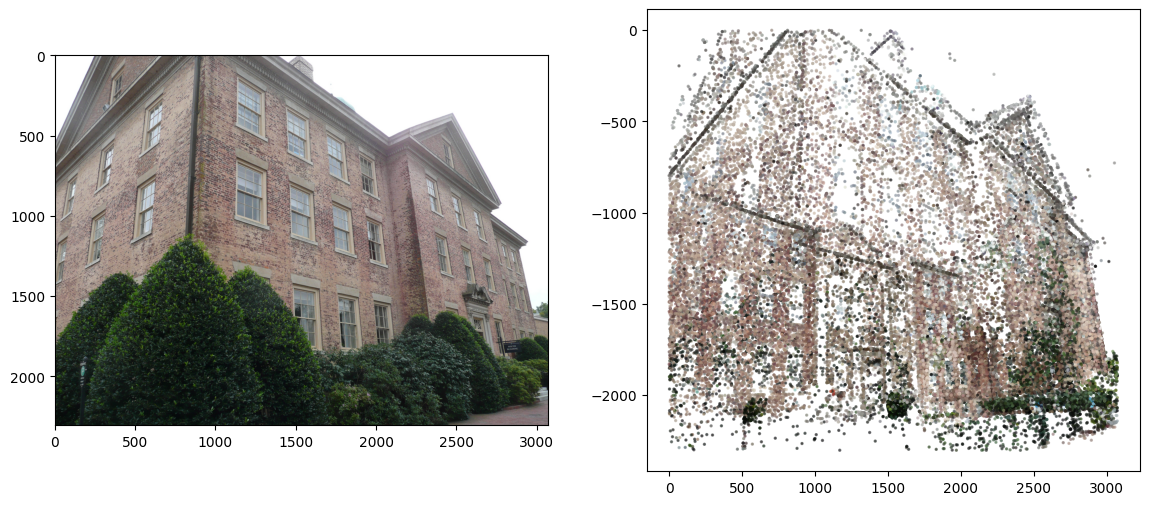

In [47]:
from src.geometry.point_transformation import projection_from_reconstruction, filter_view_points

img_id = 60
img = reconstruction.images[img_id]
img_name = img.name
img_points, colors = projection_from_reconstruction(reconstruction, img_id)
points, colors = filter_view_points(img_points, colors, width, height)
image = mpimg.imread(images_folder / f'{img_name}')
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.scatter(points[:, 0], -points[:, 1], alpha=0.5, c=colors, s=2)

In [48]:
image.shape

(2304, 3072, 3)

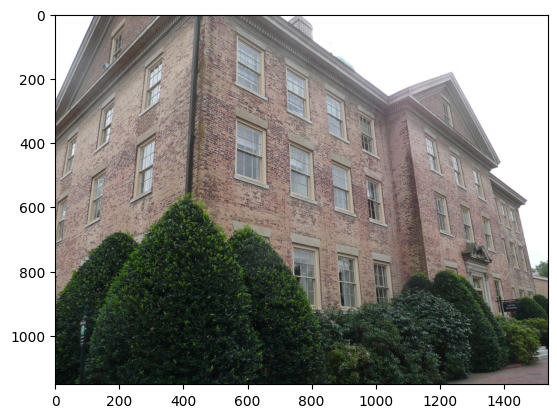

In [49]:
downscaled = downscale_local_mean(image, (2, 2, 1)).astype(np.uint8)
plt.imshow(downscaled)

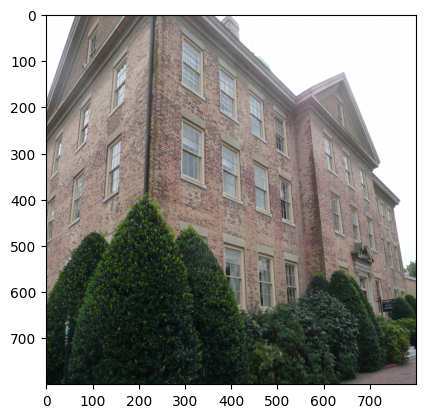

In [50]:
plt.imshow(resize(downscaled, (800, 800)))